# Imports

In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import folium

from bds_courseware import read_drive_dataset
from bds_courseware import HOMEWORK_DATASETS

from sklearn.preprocessing import minmax_scale

from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_mutual_info_score

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN


# Helping functions


In [32]:
def cluster_visualisation(data):
    # Create a 3x2 grid for subplots
    fig, axs = plt.subplots(3, 2, figsize=(20, 15))

    # Plotting the clusters for Latitude vs Longitude
    sns.scatterplot(x='Latitude', y='Longitude', hue='cluster', data=data, ax=axs[0, 0])
    axs[0, 0].set_title('Clusters Latitude vs Longitude')

    # Plotting the clusters for Focal depth vs Latitude
    sns.scatterplot(x='Latitude', y='Focal depth', hue='cluster', data=data, ax=axs[0, 1])
    axs[0, 1].set_title('Clusters Focal depth vs Latitude')

    # Plotting the clusters for Focal depth vs Longitude
    sns.scatterplot(x='Focal depth', y='Longitude', hue='cluster', data=data, ax=axs[1, 0])
    axs[1, 0].set_title('Clusters Focal depth vs Longitude')

    # Plotting the clusters for Focal depth vs Richter
    sns.scatterplot(x='Focal depth', y='Richter', hue='cluster', data=data, ax=axs[1, 1])
    axs[1, 1].set_title('Clusters Focal depth vs Richter')

    # Plotting the clusters for Latitude vs Richter
    sns.scatterplot(x='Latitude', y='Richter', hue='cluster', data=data, ax=axs[2, 0])
    axs[2, 0].set_title('Clusters Latitude vs Richter')

    # Plotting the clusters for Longitude vs Richter
    sns.scatterplot(x='Longitude', y='Richter', hue='cluster', data=data, ax=axs[2, 1])
    axs[2, 1].set_title('Clusters Longitude vs Richter')

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plot
    plt.show()



In [ ]:
def get_best_model_agg_or_k_means(data, model_name):
    # Initialize variables
    best_score = 0
    best_model = None
    best_n_clusters = 0

    # Loop over the number of clusters
    for n_clusters in range(2, 11):
        # Create the model
        if model_name == 'Agglomerative':
            model = AgglomerativeClustering(n_clusters=n_clusters)
        elif model_name == 'KMeans':
            model = KMeans(n_clusters=n_clusters)

        # Fit the model
        model.fit(data)

        # Get the cluster labels
        cluster_labels = model.labels_

        # Calculate the silhouette score
        score = silhouette_score(data, cluster_labels)

        # If the score is better than the best score, update the best score and the best model
        if score > best_score:
            best_score = score
            best_model = model
            best_n_clusters = n_clusters

    return best_model, best_n_clusters, best_score

# Data

In [33]:
print("Dataset names: ", HOMEWORK_DATASETS.keys())
name = "quake"
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
print(df.head(2))
print(df.shape)

Dataset names:  dict_keys(['suicide_rates', 'car_perfs', 'brain', 'bank', 'air_quality', 'hypothyroid', 'movies', 'bike_sharing_day', 'bike_sharing_hour', 'quake'])
   Focal depth  Latitude  Longitude  Richter
0           33    -52.26      28.30      6.7
1           36     45.53     150.93      5.8
(2178, 4)


# EDA & Data preprocessing

In [34]:
"""No missing values. All columns are numeric, Impressive, very nice!"""
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


In [35]:
"""I definitely should scale the data before training the model"""
df.describe()

Focal depth     Latitude    Longitude      Richter
count  2178.000000  2178.000000  2178.000000  2178.000000
mean     74.359963     7.961997    54.914835     5.977181
std     116.467797    30.545583   118.875581     0.189426
min       0.000000   -66.490000  -179.960000     5.800000
25%      21.000000   -12.432500   -67.782500     5.800000
50%      39.000000     0.210000   122.100000     5.900000
75%      68.000000    36.480000   146.860000     6.100000
max     656.000000    78.150000   180.000000     6.900000

In [36]:
# Scaling the data
df_scaled = minmax_scale(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.describe()

Focal depth     Latitude    Longitude      Richter
count  2178.000000  2178.000000  2178.000000  2178.000000
mean      0.113354     0.514740     0.652503     0.161074
std       0.177542     0.211184     0.330247     0.172206
min       0.000000     0.000000     0.000000     0.000000
25%       0.032012     0.373738     0.311639     0.000000
50%       0.059451     0.461145     0.839149     0.090909
75%       0.103659     0.711905     0.907934     0.272727
max       1.000000     1.000000     1.000000     1.000000

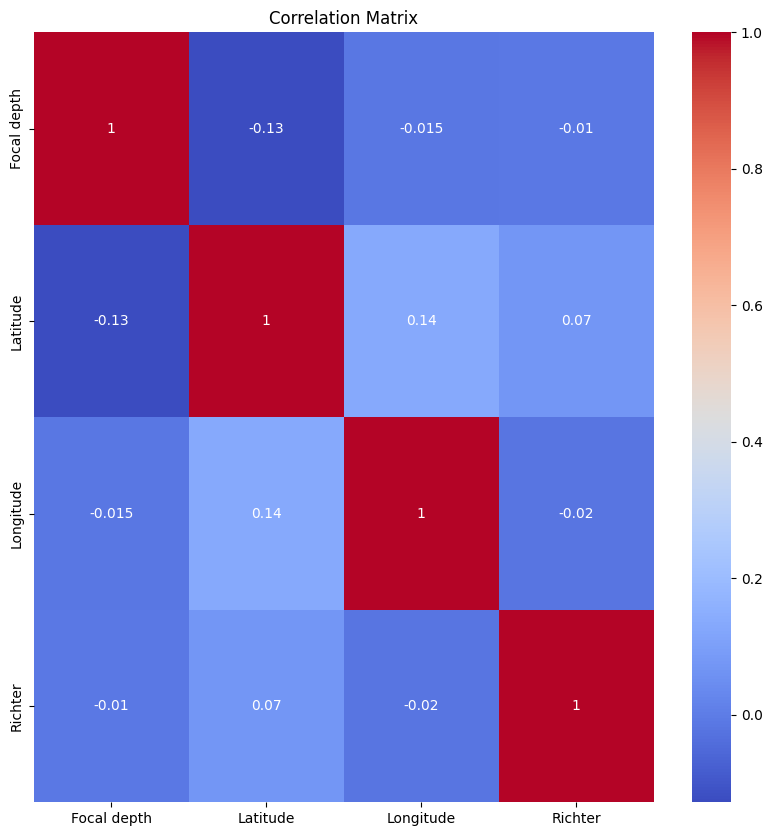

In [37]:
"""Correlatoin is weak :("""
# Correlation matrix
corr = df_scaled.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

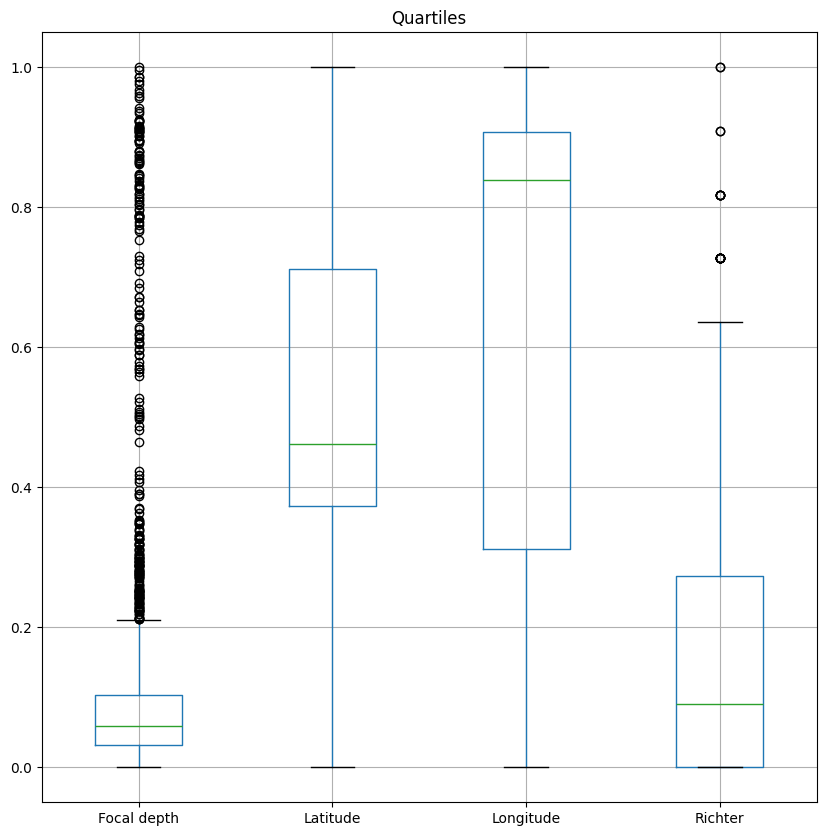

In [38]:
"""A lot of outliers for focal depth, if I don`t get positive results, I will consider additional preprocessing"""
# Plotting quartiles
plt.figure(figsize=(10, 10))
df_scaled.boxplot()
plt.title('Quartiles')
plt.show()


# K-Means

Silhouette Score for K-Means with 15 clusters: 0.34308988164663295


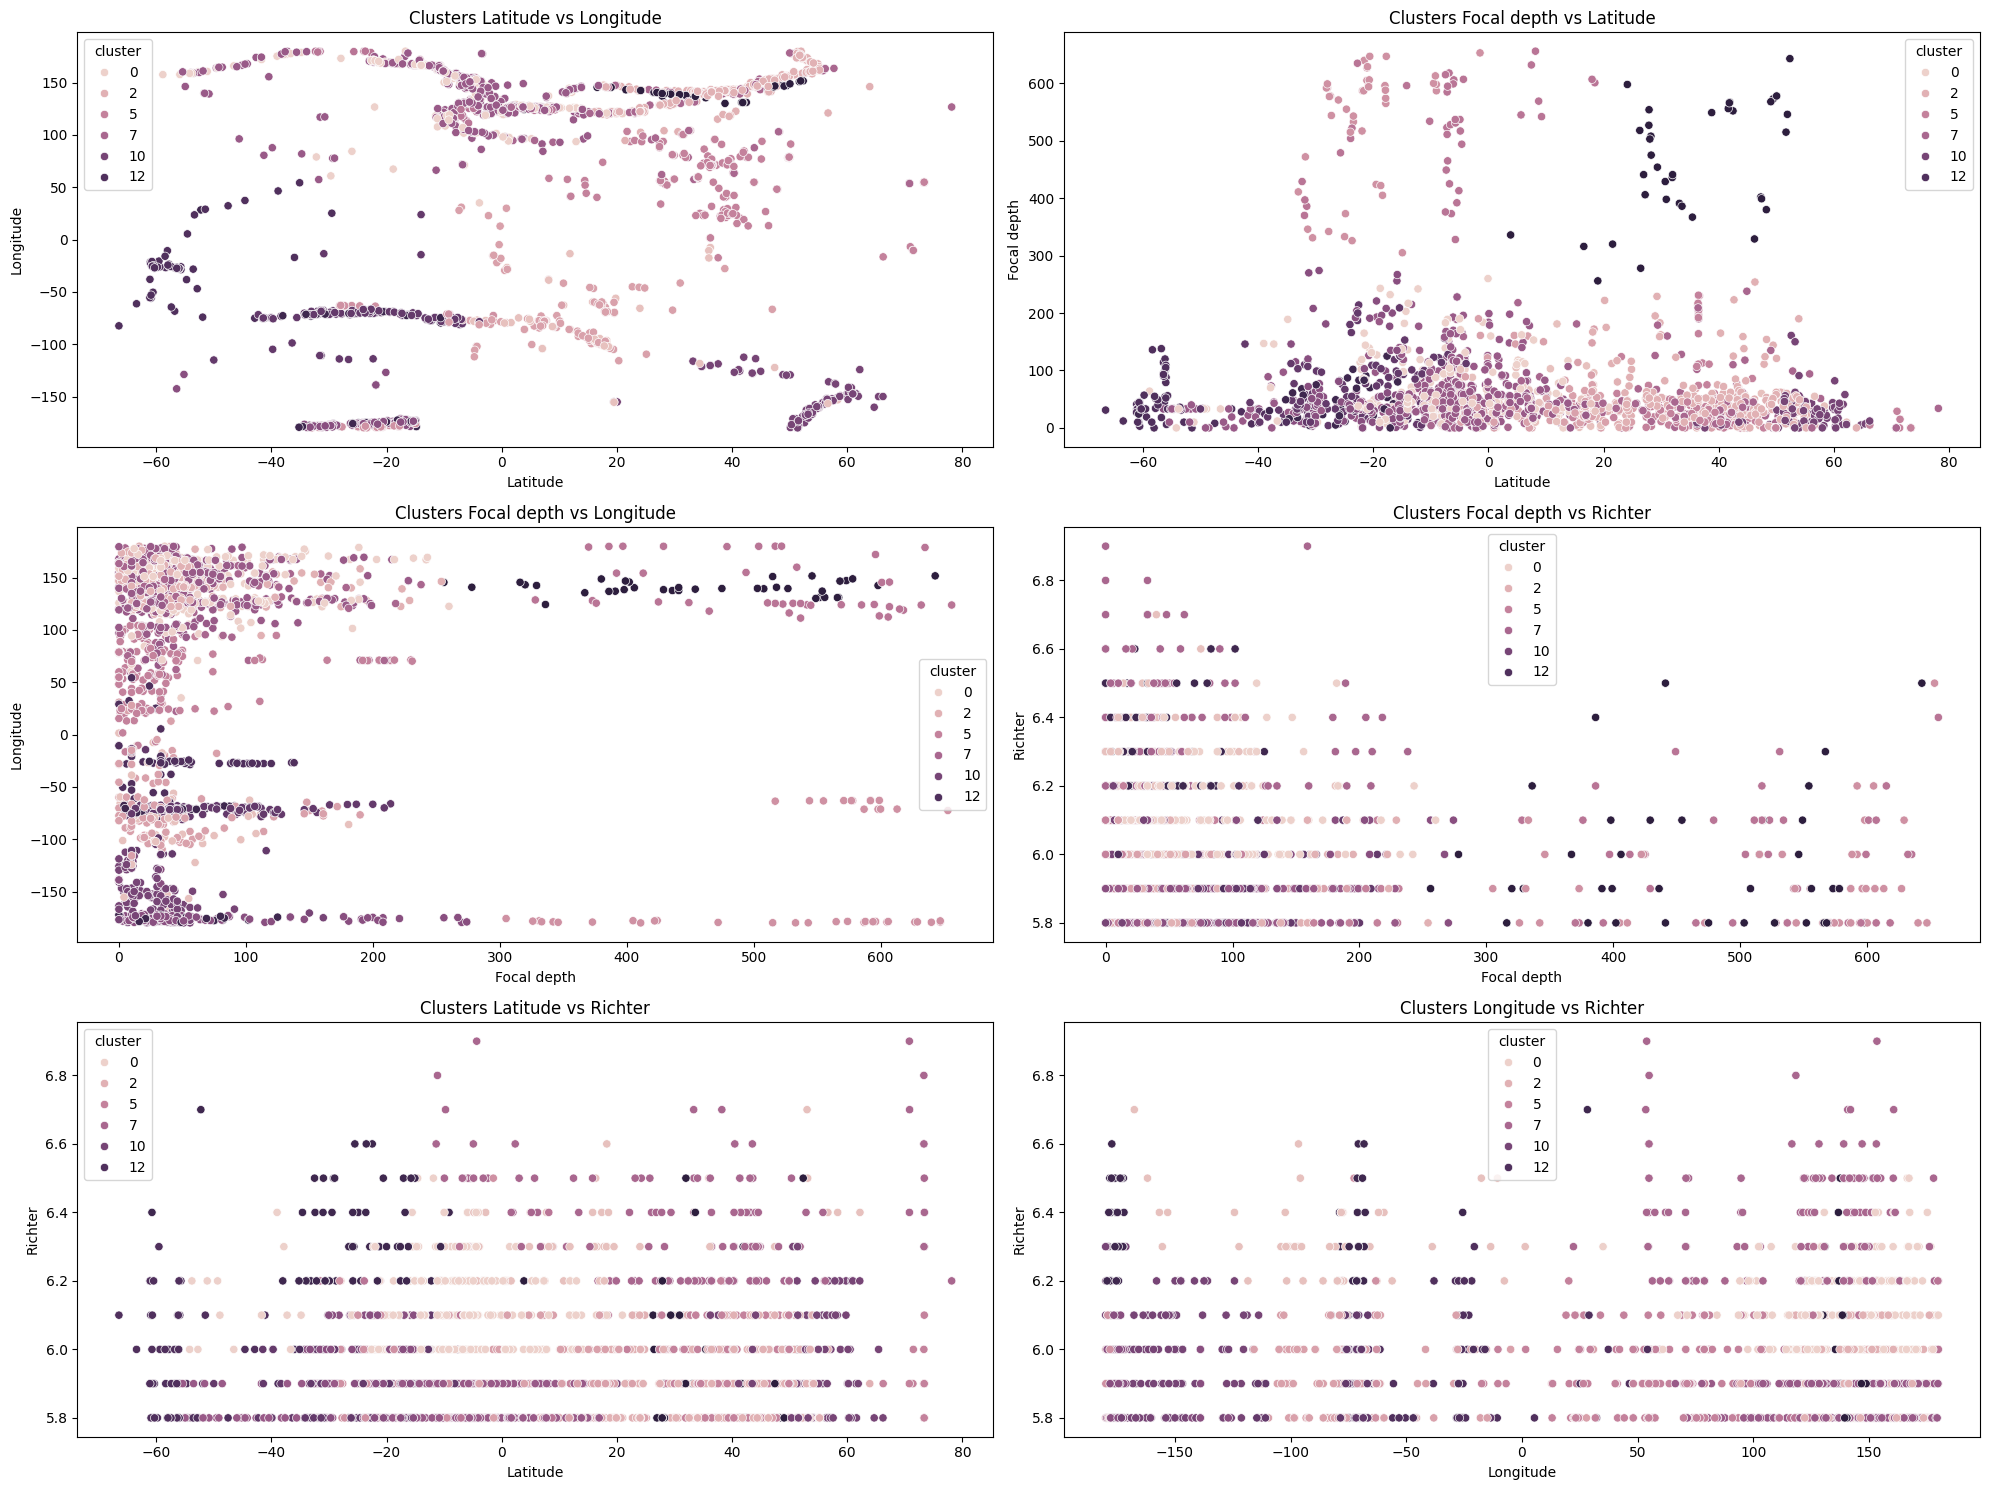

In [39]:
# K-Means with 15 clusters
kmeans = KMeans(n_clusters=15, random_state=42)

# Fitting the model
kmeans.fit(df_scaled)

# Predicting the clusters
df['cluster'] = kmeans.predict(df_scaled)

# Calculating silhouette score
k_means_15_silhouette_score = silhouette_score(df_scaled, df['cluster'])
print(f'Silhouette Score for K-Means with 15 clusters: {k_means_15_silhouette_score}')

# Visualising the clusters
cluster_visualisation(df)




Best Silhouette Score: 0.4755817364809831 for K-Means with 2 clusters


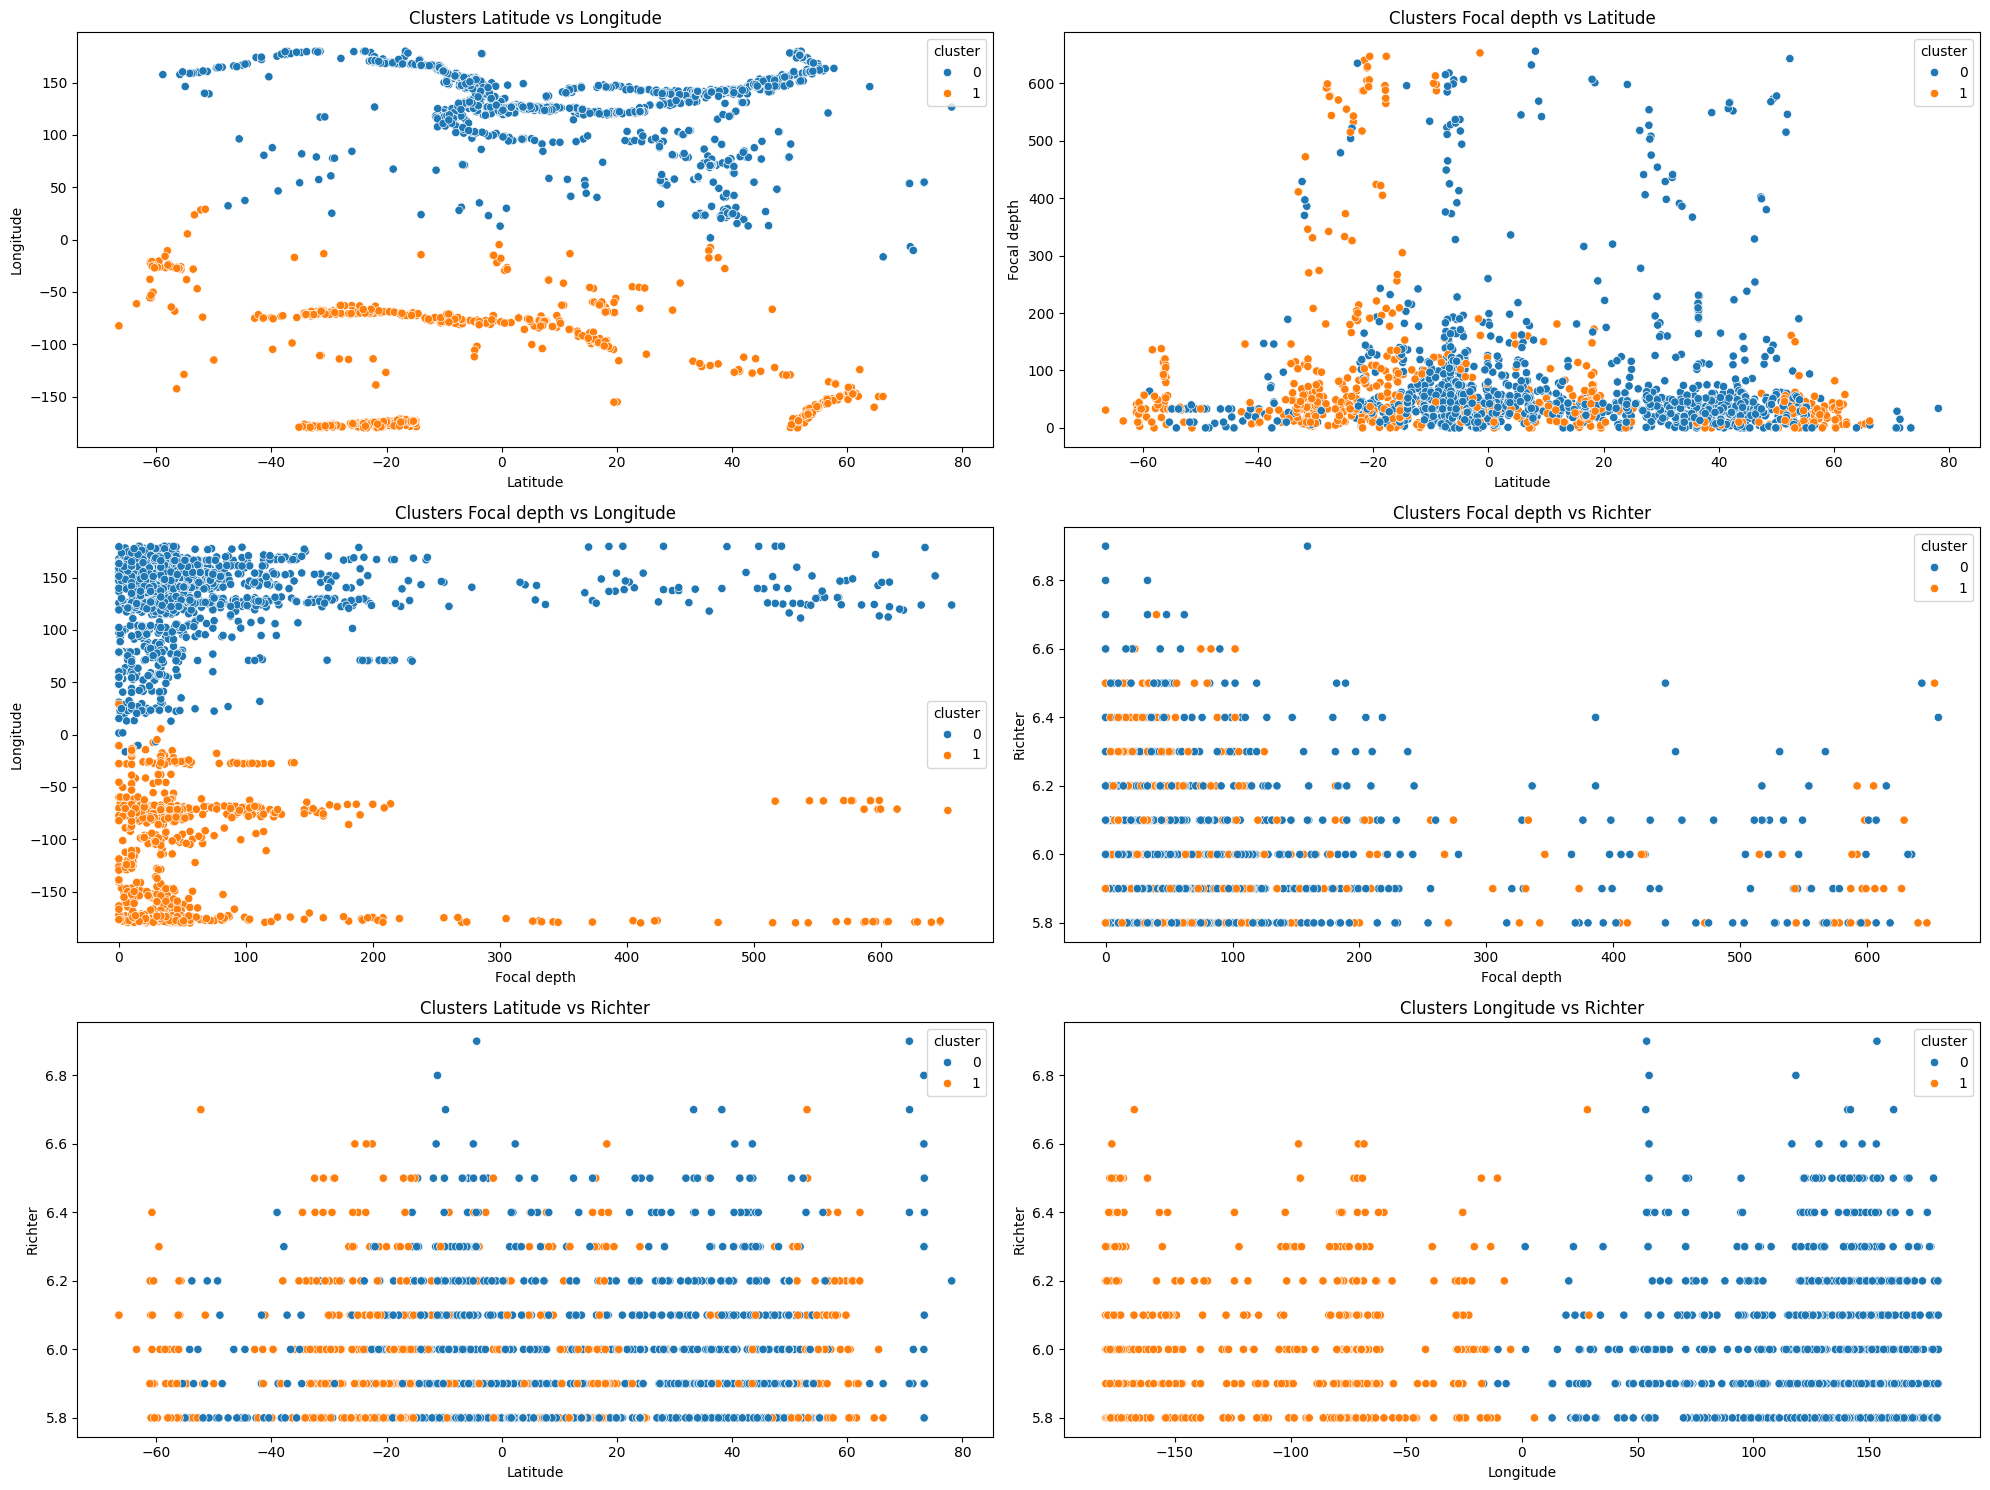

In [40]:
# K-Means with grid search for the best number of clusters
best_model, best_n_clusters, best_score = get_best_model_agg_or_k_means(df_scaled, 'KMeans')

print(f'Best Silhouette Score: {best_score} for K-Means with {best_n_clusters} clusters')

df['cluster'] = best_model.predict(df_scaled)
k_means_best_result = df['cluster']

# Plotting the best clusters
cluster_visualisation(df)

# Agglomerative clustering

Adjusted Mutual Info Score: 0.7679312809855742
Best Silhouette Score: 0.4802504753679641 for Agglomerative Clustering with 3 clusters


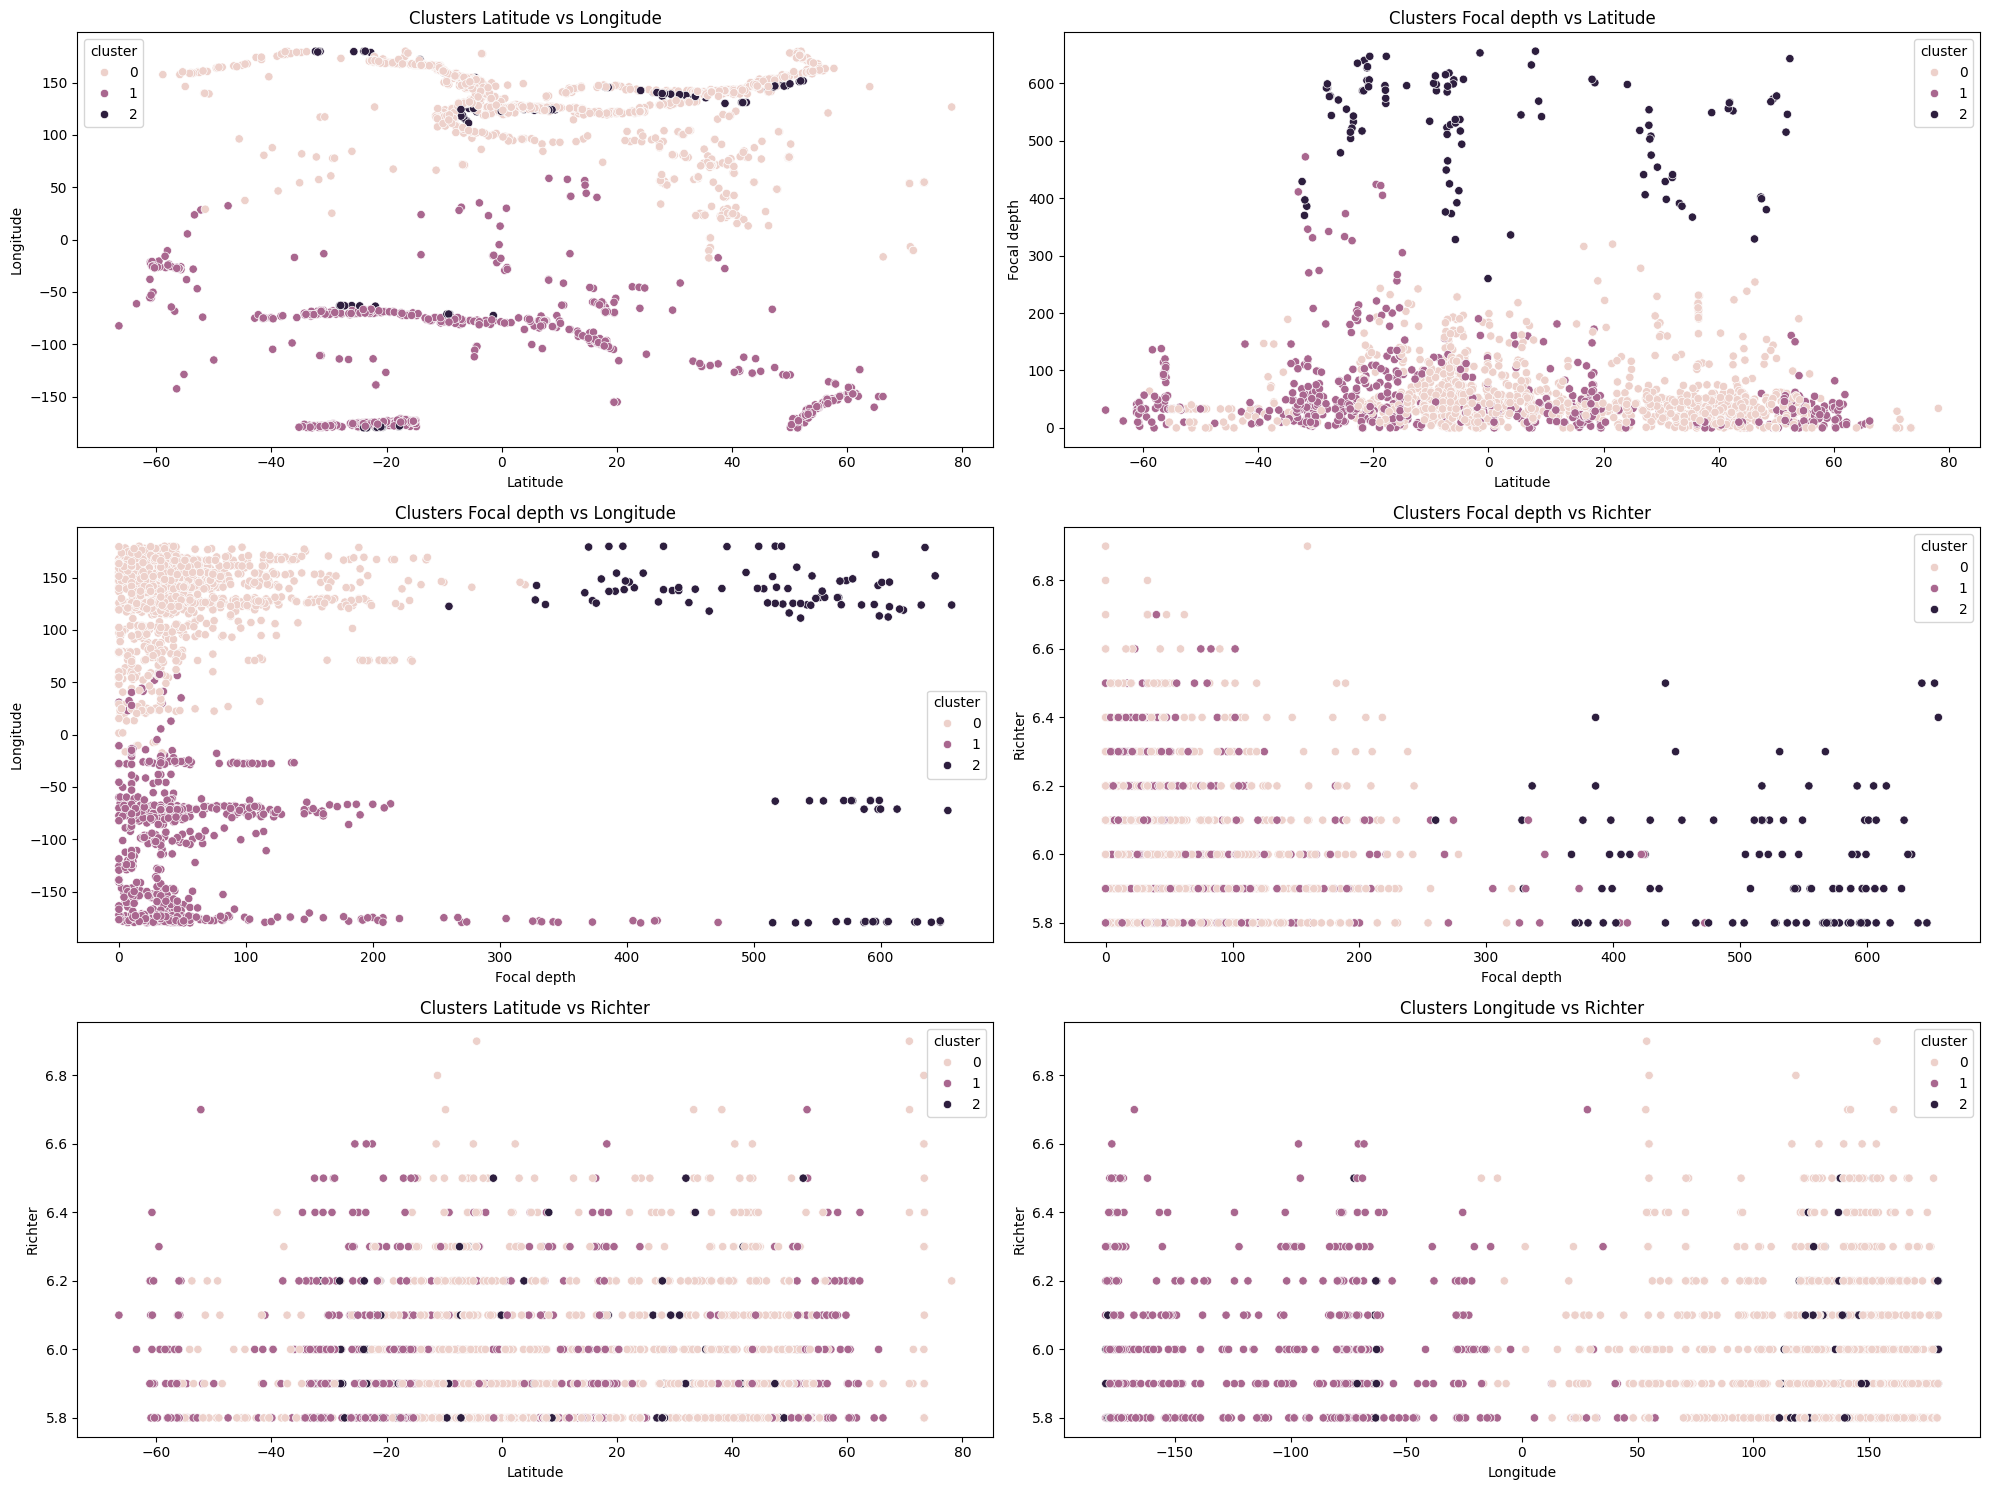

In [41]:
# Agglomerative Clustering with grid search for the best number of clusters
best_model, best_n_clusters, best_score = get_best_model_agg_or_k_means(df_scaled, 'Agglomerative')
    
df['cluster'] = best_model.fit_predict(df_scaled)
agg_best_result = df['cluster']

# Print metrics
print(f'Adjusted Mutual Info Score: {adjusted_mutual_info_score(k_means_best_result, agg_best_result)}')
print(f'Best Silhouette Score: {best_score} for Agglomerative Clustering with {best_n_clusters} clusters')

# Plotting the best clusters
cluster_visualisation(df)



# DBScan

Best Silhouette Score: 0.36768446500507945 for DBSCAN with eps=0.30000000000000004 and min_samples=2
Adjusted Mutual Info Score: 0.023495564264404162


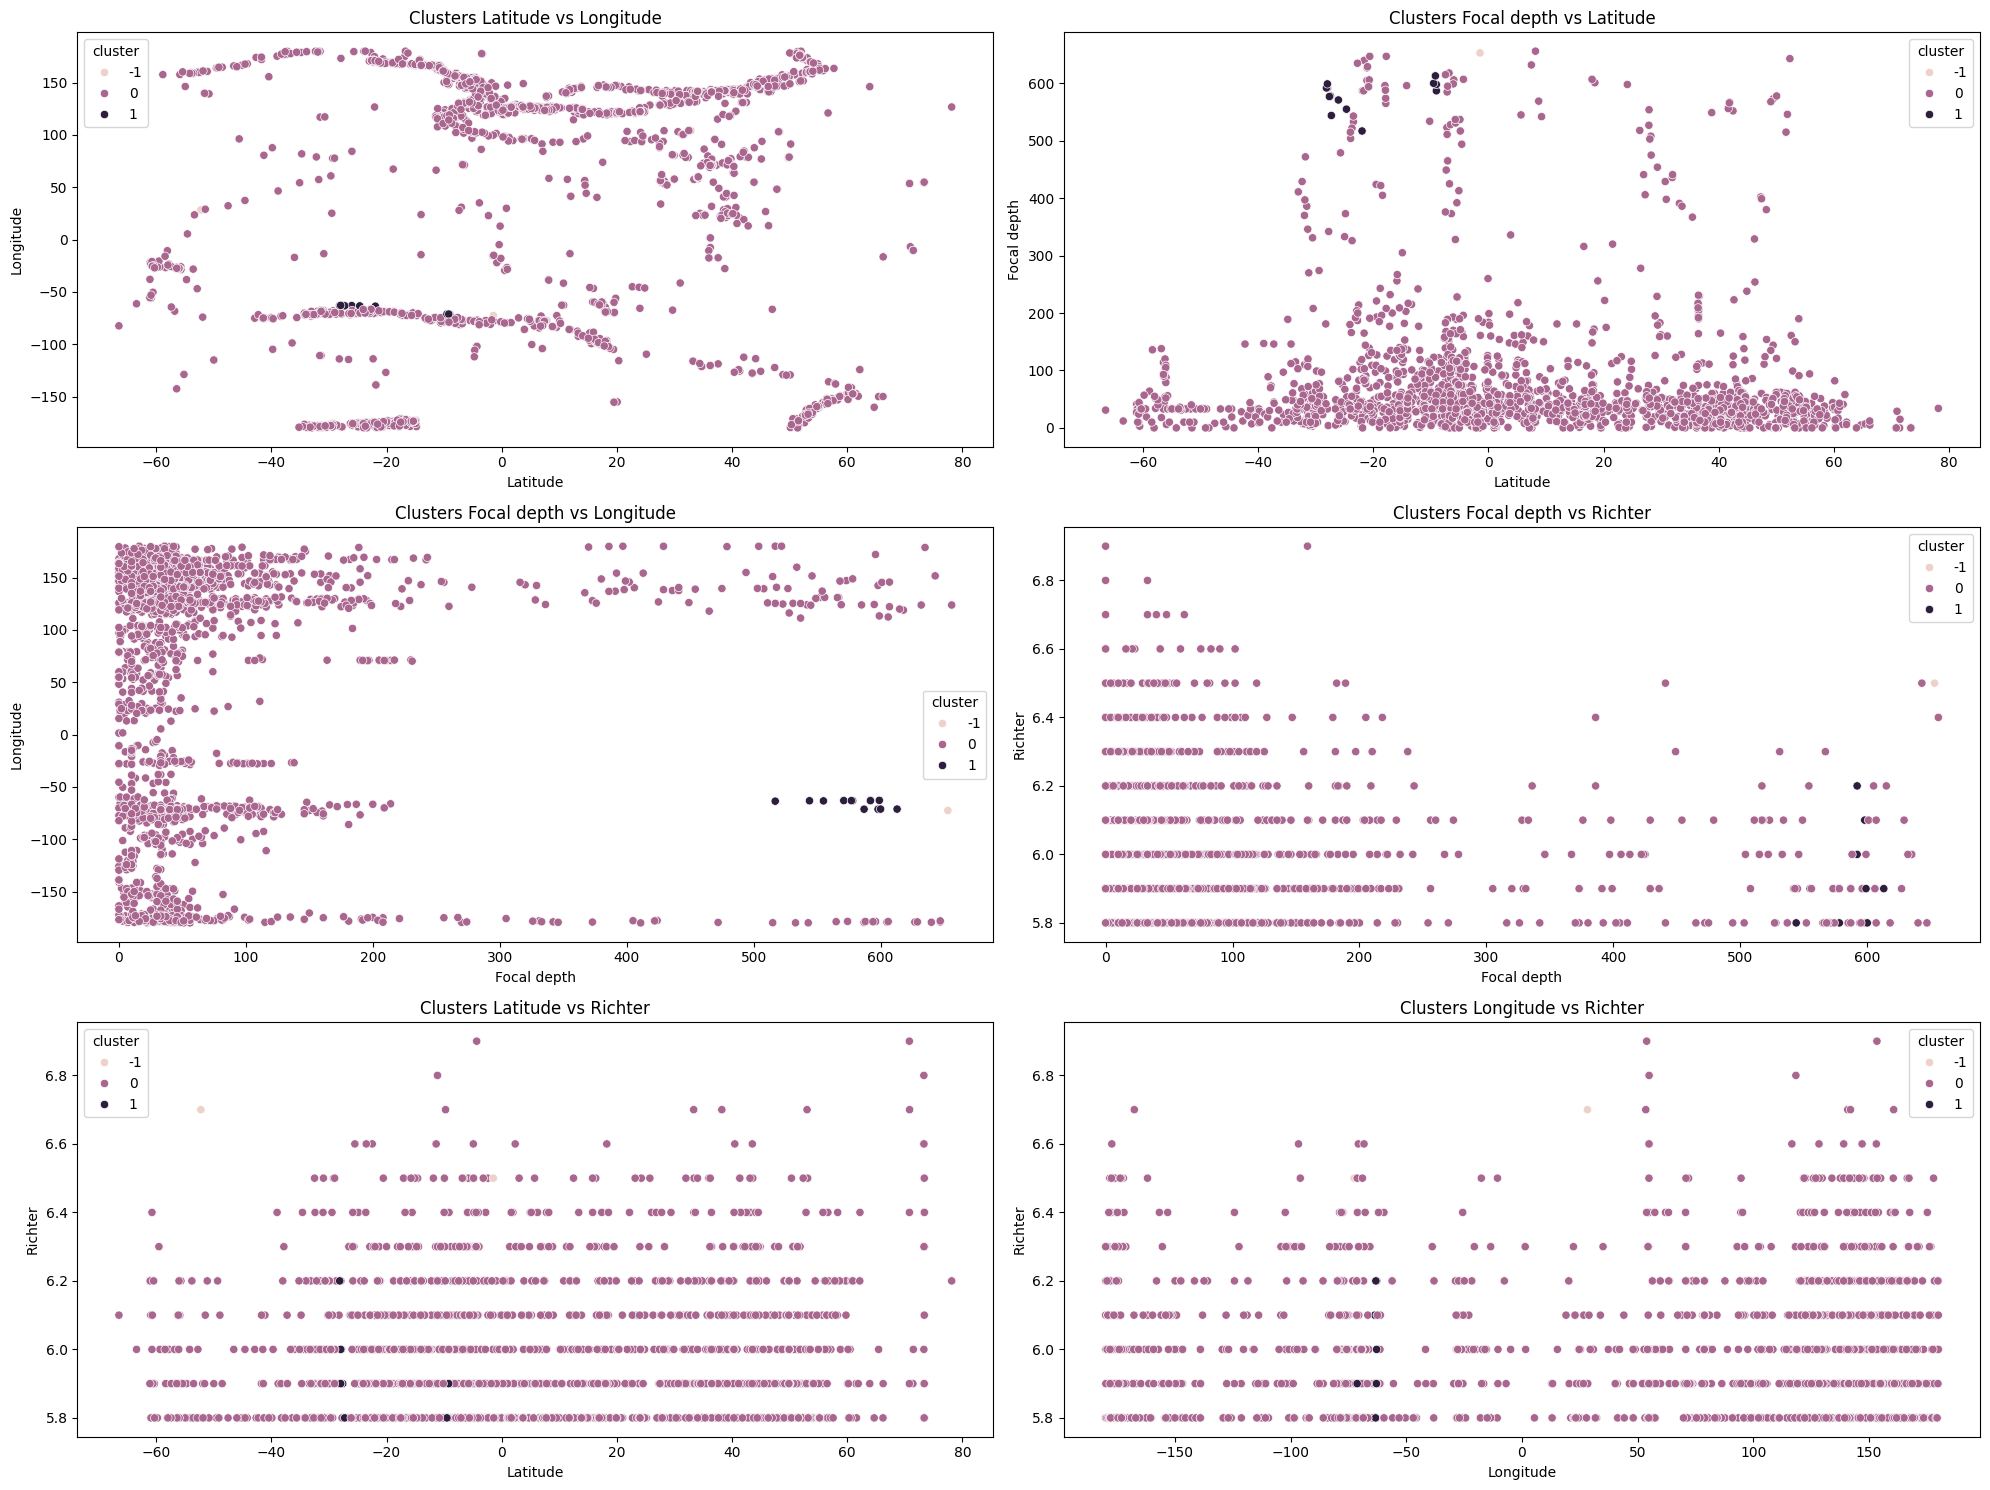

In [45]:
# DBSCAN with grid search for the best eps and min_samples
best_score = 0
best_model = None
best_eps = 0
best_min_samples = 0

for eps in np.arange(0.1, 1.1, 0.1):
    for min_samples in range(2, 11):
        # Create the model
        model = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit the model
        model.fit(df_scaled)

        # Get the cluster labels
        cluster_labels = model.labels_

        if len(set(cluster_labels)) > 1:
            # Calculate the silhouette score
            score = silhouette_score(df_scaled, cluster_labels)

            # If the score is better than the best score, update the best score and the best model
            if score > best_score:
                best_score = score
                best_model = model
                best_eps = eps
                best_min_samples = min_samples

# Predicting the clusters
df['cluster'] = best_model.fit_predict(df_scaled)
dbscan_best_result = df['cluster']

# Print metrics
print(f'Best Silhouette Score: {best_score} for DBSCAN with eps={best_eps} and min_samples={best_min_samples}')
print(f'Adjusted Mutual Info Score: {adjusted_mutual_info_score(k_means_best_result, dbscan_best_result)}')

# Plotting the best clusters
cluster_visualisation(df)

# Conclusions

Among DBScan, K-Means and Agglomerative clustering, i think that for this task the best choice is the third one.
It looks like DBScan just showed some outliers.
K-Means showed best results with 2 clusters, and taken into account longitude mostly.
Although Agglomerative clustering didn't show much better score, from the scatter plots we see, that it also builded clusters considering focal depth, and made 3 clusters instead of 2.

# World map

In [53]:
# Visualizing Agglomerative clastering on world map

df['cluster'] = agg_best_result
print(df.head())

# Create a map
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=2)

colors = ['#FF0000', '#00FF00', '#0000FF']

# Add the data points to the map
for index, row in df.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']], radius=5, color=colors[int(row['cluster'])], fill=True).add_to(m)

# Show the map
m.save('Agglomerative_Clustering.html')
m

   Focal depth  Latitude  Longitude  Richter  cluster
0           33    -52.26      28.30      6.7        1
1           36     45.53     150.93      5.8        0
2           57     41.85     142.78      5.8        0
3           67     29.19     141.15      6.2        0
4           30    -21.66     169.81      6.0        0
